In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import *
from collections import Counter
import pickle as pkl
import gradio as gr

# ========== LOAD DATA ==========

In [2]:
imsData = pd.read_csv("ikimina_loan_Dataset.csv")
imsData

,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,Age,RecentLoanPaymentStatus,SavingStatus,SavingRatingFactor,SavingRatio,ExpectedLoan,BoostAmount,AllowedLoan
0,1,daily,1,365,238,49,8300204,2019,2023,employed,True,19,Excellent,Poor,0.2,0.21,2545860.89,876343.08,3422203.97
1,2,daily,1,365,217,80,1872561,2020,2020,employed,True,19,Excellent,Poor,0.2,0.37,629939.88,267035.00,896974.87
2,3,daily,1,365,317,42,9755468,2018,2018,employed,True,19,Excellent,Poor,0.2,0.13,2246527.33,713910.24,2960437.57
3,4,daily,1,365,197,30,9335973,2022,2022,employed,True,19,Excellent,Poor,0.2,0.15,3459522.99,1584663.48,5044186.47
4,5,daily,1,365,122,113,4927418,2016,2017,employed,True,19,Excellent,Better,0.8,0.93,11793492.26,5651048.38,9854836.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,monthly,15,180,41,37,3893735,2016,2020,unemployed,False,11,Poor,Better,0.8,0.90,13675557.07,4159648.61,7787470.00
34996,34997,monthly,15,180,58,12,8873260,2015,2018,unemployed,False,11,Poor,Poor,0.2,0.21,5507540.69,1734875.32,7242416.01
34997,34998,monthly,15,180,156,72,9455844,2016,2022,unemployed,False,11,Poor,Bad,0.4,0.46,4364235.69,516154.80,4880390.49
34998,34999,monthly,15,180,41,9,5415526,2016,2017,unemployed,False,11,Poor,Poor,0.2,0.22,4755096.00,1565219.10,6320315.10


In [3]:
print(imsData.shape)
print(imsData.columns)
imsData.head()


(35000, 19)
Index(['MemberID', 'SavingFrequency', 'SavingTimesPerPeriod',
       'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade',
       'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear',
       'EmploymentStatus', 'HasGuardian', 'Age', 'RecentLoanPaymentStatus',
       'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan',
       'BoostAmount', 'AllowedLoan'],
      dtype='object')


,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,Age,RecentLoanPaymentStatus,SavingStatus,SavingRatingFactor,SavingRatio,ExpectedLoan,BoostAmount,AllowedLoan
0,1,daily,1,365,238,49,8300204,2019,2023,employed,True,19,Excellent,Poor,0.2,0.21,2545860.89,876343.08,3422203.97
1,2,daily,1,365,217,80,1872561,2020,2020,employed,True,19,Excellent,Poor,0.2,0.37,629939.88,267035.00,896974.87
2,3,daily,1,365,317,42,9755468,2018,2018,employed,True,19,Excellent,Poor,0.2,0.13,2246527.33,713910.24,2960437.57
3,4,daily,1,365,197,30,9335973,2022,2022,employed,True,19,Excellent,Poor,0.2,0.15,3459522.99,1584663.48,5044186.47
4,5,daily,1,365,122,113,4927418,2016,2017,employed,True,19,Excellent,Better,0.8,0.93,11793492.26,5651048.38,9854836.00


In [4]:
def enrich_features(df, current_year):
    df['AvgSavingPerCycle'] = df['TotalCurrentSaving'] / df['UserSavingsMade'].replace(0, 1)
    df['SavingRatio'] = df['UserSavingsMade'] / df['CompletedSavingCycles'].replace(0, 1)
    df['RemainingCycles'] = df['TotalSavingCycles'] - df['CompletedSavingCycles']
    df['RemainingRatio'] = df['RemainingCycles'] / df['TotalSavingCycles'].replace(0, 1)
    df['MembershipYears'] = current_year - df['UserJoinedYear']
    df['IkiminaAge'] = current_year - df['IkiminaCreatedYear']
    df['MembershipRatio'] = df['MembershipYears'] / df['IkiminaAge'].replace(0, 1)
    df['HasGuardian'] = df['HasGuardian'].astype(int)
    df['IsEmployed'] = df['EmploymentStatus'].apply(lambda x: 1 if x == 'employed' else 0)
    return df

imsData = enrich_features(imsData, current_year=2025)
imsData

,MemberID,SavingFrequency,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,...,ExpectedLoan,BoostAmount,AllowedLoan,AvgSavingPerCycle,RemainingCycles,RemainingRatio,MembershipYears,IkiminaAge,MembershipRatio,IsEmployed
0,1,daily,1,365,238,49,8300204,2019,2023,employed,...,2545860.89,876343.08,3422203.97,169391.918367,127,0.347945,2,6,0.333333,1
1,2,daily,1,365,217,80,1872561,2020,2020,employed,...,629939.88,267035.00,896974.87,23407.012500,148,0.405479,5,5,1.000000,1
2,3,daily,1,365,317,42,9755468,2018,2018,employed,...,2246527.33,713910.24,2960437.57,232273.047619,48,0.131507,7,7,1.000000,1
3,4,daily,1,365,197,30,9335973,2022,2022,employed,...,3459522.99,1584663.48,5044186.47,311199.100000,168,0.460274,3,3,1.000000,1
4,5,daily,1,365,122,113,4927418,2016,2017,employed,...,11793492.26,5651048.38,9854836.00,43605.469027,243,0.665753,8,9,0.888889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,monthly,15,180,41,37,3893735,2016,2020,unemployed,...,13675557.07,4159648.61,7787470.00,105236.081081,139,0.772222,5,9,0.555556,0
34996,34997,monthly,15,180,58,12,8873260,2015,2018,unemployed,...,5507540.69,1734875.32,7242416.01,739438.333333,122,0.677778,7,10,0.700000,0
34997,34998,monthly,15,180,156,72,9455844,2016,2022,unemployed,...,4364235.69,516154.80,4880390.49,131331.166667,24,0.133333,3,9,0.333333,0
34998,34999,monthly,15,180,41,9,5415526,2016,2017,unemployed,...,4755096.00,1565219.10,6320315.10,601725.111111,139,0.772222,8,9,0.888889,0


In [5]:

def encode_features(df):
    cat_cols = ['SavingFrequency', 'RecentLoanPaymentStatus']
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
    
    df = df.drop(columns=cat_cols).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)
    return df


In [6]:
imsData = encode_features(imsData)
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,238,49,8300204,2019,2023,employed,1,...,0.333333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,217,80,1872561,2020,2020,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,317,42,9755468,2018,2018,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,197,30,9335973,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,122,113,4927418,2016,2017,employed,1,...,0.888889,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,15,180,41,37,3893735,2016,2020,unemployed,0,...,0.555556,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34996,34997,15,180,58,12,8873260,2015,2018,unemployed,0,...,0.700000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34997,34998,15,180,156,72,9455844,2016,2022,unemployed,0,...,0.333333,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34998,34999,15,180,41,9,5415526,2016,2017,unemployed,0,...,0.888889,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
print(imsData.columns.tolist())

['MemberID', 'SavingTimesPerPeriod', 'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade', 'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear', 'EmploymentStatus', 'HasGuardian', 'Age', 'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan', 'BoostAmount', 'AllowedLoan', 'AvgSavingPerCycle', 'RemainingCycles', 'RemainingRatio', 'MembershipYears', 'IkiminaAge', 'MembershipRatio', 'IsEmployed', 'SavingFrequency_daily', 'SavingFrequency_monthly', 'SavingFrequency_weekly', 'RecentLoanPaymentStatus_Bad', 'RecentLoanPaymentStatus_Better', 'RecentLoanPaymentStatus_Excellent', 'RecentLoanPaymentStatus_Good', 'RecentLoanPaymentStatus_Poor']


In [8]:
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,238,49,8300204,2019,2023,employed,1,...,0.333333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,217,80,1872561,2020,2020,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,317,42,9755468,2018,2018,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,197,30,9335973,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,122,113,4927418,2016,2017,employed,1,...,0.888889,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,15,180,41,37,3893735,2016,2020,unemployed,0,...,0.555556,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34996,34997,15,180,58,12,8873260,2015,2018,unemployed,0,...,0.700000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34997,34998,15,180,156,72,9455844,2016,2022,unemployed,0,...,0.333333,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34998,34999,15,180,41,9,5415526,2016,2017,unemployed,0,...,0.888889,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# ========== ENCODE season and location_type AS INTEGERS ==========

In [9]:
imsData

,MemberID,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,EmploymentStatus,HasGuardian,...,MembershipRatio,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,1,365,238,49,8300204,2019,2023,employed,1,...,0.333333,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,1,365,217,80,1872561,2020,2020,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,365,317,42,9755468,2018,2018,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,365,197,30,9335973,2022,2022,employed,1,...,1.000000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,365,122,113,4927418,2016,2017,employed,1,...,0.888889,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,15,180,41,37,3893735,2016,2020,unemployed,0,...,0.555556,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34996,34997,15,180,58,12,8873260,2015,2018,unemployed,0,...,0.700000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34997,34998,15,180,156,72,9455844,2016,2022,unemployed,0,...,0.333333,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34998,34999,15,180,41,9,5415526,2016,2017,unemployed,0,...,0.888889,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis

# ========== SELECT FEATURES AND TARGET ==========

In [10]:
final_features = [
    'SavingTimesPerPeriod',
    'TotalSavingCycles',
    'CompletedSavingCycles',
    'UserSavingsMade',
    'TotalCurrentSaving',
    'IkiminaCreatedYear',
    'UserJoinedYear',
    'Age',
    'HasGuardian',
    'IsEmployed',
    'SavingFrequency_daily',
    'SavingFrequency_monthly',
    'SavingFrequency_weekly',
    'RecentLoanPaymentStatus_Bad',
    'RecentLoanPaymentStatus_Better',
    'RecentLoanPaymentStatus_Excellent',
    'RecentLoanPaymentStatus_Good',
    'RecentLoanPaymentStatus_Poor'
]

X = imsData[final_features]
y = imsData['AllowedLoan']


In [11]:
X

,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,Age,HasGuardian,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
0,1,365,238,49,8300204,2019,2023,19,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,365,217,80,1872561,2020,2020,19,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,365,317,42,9755468,2018,2018,19,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,365,197,30,9335973,2022,2022,19,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,365,122,113,4927418,2016,2017,19,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,15,180,41,37,3893735,2016,2020,11,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34996,15,180,58,12,8873260,2015,2018,11,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34997,15,180,156,72,9455844,2016,2022,11,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34998,15,180,41,9,5415526,2016,2017,11,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
y

0        3422203.97
1         896974.87
2        2960437.57
3        5044186.47
4        9854836.00
            ...    
34995    7787470.00
34996    7242416.01
34997    4880390.49
34998    6320315.10
34999    2227616.08
Name: AllowedLoan, Length: 35000, dtype: float64

# ========== SPLIT DATA ==========

In [13]:
# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ========== Train models ==========

In [14]:
X_test

,SavingTimesPerPeriod,TotalSavingCycles,CompletedSavingCycles,UserSavingsMade,TotalCurrentSaving,IkiminaCreatedYear,UserJoinedYear,Age,HasGuardian,IsEmployed,SavingFrequency_daily,SavingFrequency_monthly,SavingFrequency_weekly,RecentLoanPaymentStatus_Bad,RecentLoanPaymentStatus_Better,RecentLoanPaymentStatus_Excellent,RecentLoanPaymentStatus_Good,RecentLoanPaymentStatus_Poor
17813,8,96,48,31,3484715,2017,2023,57,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6857,2,104,90,22,4473865,2018,2018,56,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7672,2,104,36,29,3161753,2017,2024,4,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9704,2,104,43,39,2257092,2015,2018,42,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14303,14,168,133,62,7952018,2015,2022,52,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8045,2,104,16,14,7851526,2020,2020,95,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
33786,15,180,103,50,6213580,2015,2016,74,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13208,14,168,19,4,8450013,2017,2020,79,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
24073,11,132,57,11,8458014,2017,2018,32,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### ========== MODEL 1: Random Forest ==========

In [15]:
randomModel = RandomForestRegressor(n_estimators=100, random_state=42)
randomModel.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
rf_cv_scores = cross_val_score(randomModel, X_train, y_train, cv=5, scoring='r2')
print(f"Random Forest CV R² scores: {rf_cv_scores}")
print(f"Random Forest CV mean R²: {np.mean(rf_cv_scores):.4f}")

Random Forest CV R² scores: [0.982831   0.98327121 0.98277906 0.98437134 0.98295264]
Random Forest CV mean R²: 0.9832



### ========== MODEL 2: LinearRegression ==========

In [17]:
LinearRegrModel = LinearRegression()
LinearRegrModel.fit(X_train, y_train)

LinearRegression()

In [18]:
lr_cv_scores = cross_val_score(LinearRegrModel, X_train, y_train, cv=5, scoring='r2')
print("📈 Linear Regression CV R² scores:", lr_cv_scores)
print(f"📈 Mean R²: {np.mean(lr_cv_scores):.4f} | Std Dev: {np.std(lr_cv_scores):.4f}")

📈 Linear Regression CV R² scores: [0.67357115 0.68120418 0.69338559 0.68678215 0.6909595 ]
📈 Mean R²: 0.6852 | Std Dev: 0.0071


### ========== MODEL 3: XGBoost ==========

In [19]:
XGBModel = XGBRegressor(random_state=42)
XGBModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
xgb_cv_scores = cross_val_score(XGBModel, X_train, y_train, cv=5, scoring='r2')
print(f"XGBoost CV R² scores: {xgb_cv_scores}")
print(f"XGBoost CV mean R²: {np.mean(xgb_cv_scores):.4f}")

XGBoost CV R² scores: [0.97588679 0.97690221 0.97737943 0.97707253 0.97666438]
XGBoost CV mean R²: 0.9768


In [23]:
# Evaluate model on test set and cross-validation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics on test set
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation on training set (5-fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    print(f"📊 {name} Model Evaluation Metrics")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Coefficient of Determination (R² Score): {r2:.4f}")
    print(f"Cross-Validation R² Mean: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print("-" * 50)

    return {
        'model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV_mean_R2': cv_mean,
        'CV_std_R2': cv_std
    }


# Example usage:
results = []
results.append(evaluate_model("Random Forest", randomModel, X_train, y_train, X_test, y_test))
results.append(evaluate_model("XGBoost", XGBModel, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Linear Regression", LinearRegrModel, X_train, y_train, X_test, y_test))


📊 Random Forest Model Evaluation Metrics
Mean Absolute Error (MAE): 351953.63
Mean Squared Error (MSE): 364519463194.53
Root Mean Squared Error (RMSE): 603754.47
Coefficient of Determination (R² Score): 0.9854
Cross-Validation R² Mean: 0.9832 (+/- 0.0006)
--------------------------------------------------
📊 XGBoost Model Evaluation Metrics
Mean Absolute Error (MAE): 476644.84
Mean Squared Error (MSE): 542969364823.11
Root Mean Squared Error (RMSE): 736864.55
Coefficient of Determination (R² Score): 0.9782
Cross-Validation R² Mean: 0.9768 (+/- 0.0005)
--------------------------------------------------
📊 Linear Regression Model Evaluation Metrics
Mean Absolute Error (MAE): 2083597.37
Mean Squared Error (MSE): 7731793121785.80
Root Mean Squared Error (RMSE): 2780610.21
Coefficient of Determination (R² Score): 0.6894
Cross-Validation R² Mean: 0.6852 (+/- 0.0071)
--------------------------------------------------


In [24]:
cv_summary = {
    "Random Forest": {"mean_r2": np.mean(rf_cv_scores), "std": np.std(rf_cv_scores)},
    "XGBoost": {"mean_r2": np.mean(xgb_cv_scores), "std": np.std(xgb_cv_scores)},
    "Linear Regression": {"mean_r2": np.mean(lr_cv_scores), "std": np.std(lr_cv_scores)},
}


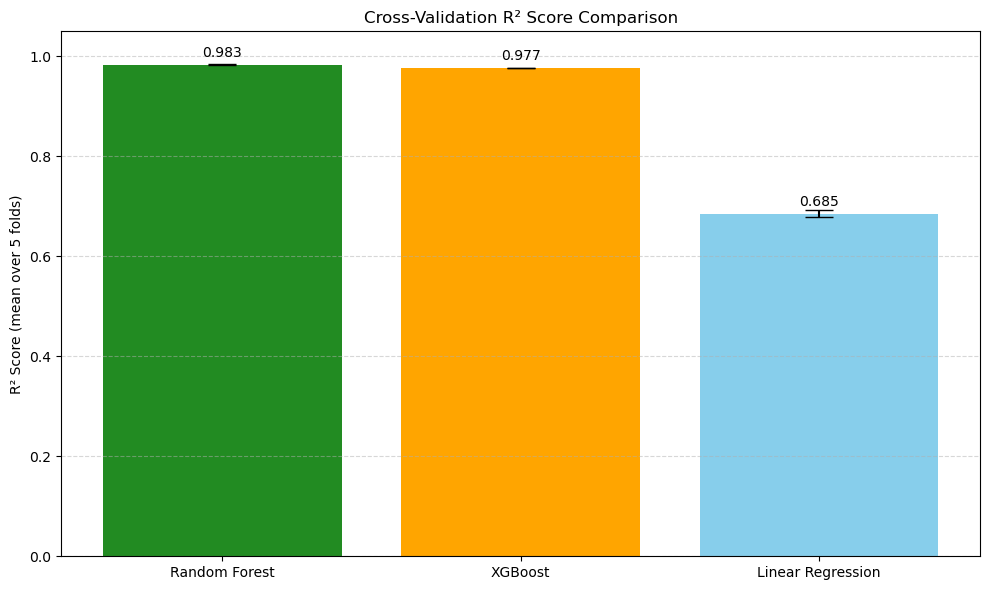

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_names = ['Random Forest', 'XGBoost', 'Linear Regression']
mean_r2_scores = [
    np.mean(rf_cv_scores),
    np.mean(xgb_cv_scores),
    np.mean(lr_cv_scores)
]
std_devs = [
    np.std(rf_cv_scores),
    np.std(xgb_cv_scores),
    np.std(lr_cv_scores)
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mean_r2_scores, yerr=std_devs, capsize=10, color=['forestgreen', 'orange', 'skyblue'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}', ha='center', va='bottom')

# Formatting
plt.title("Cross-Validation R² Score Comparison")
plt.ylabel("R² Score (mean over 5 folds)")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


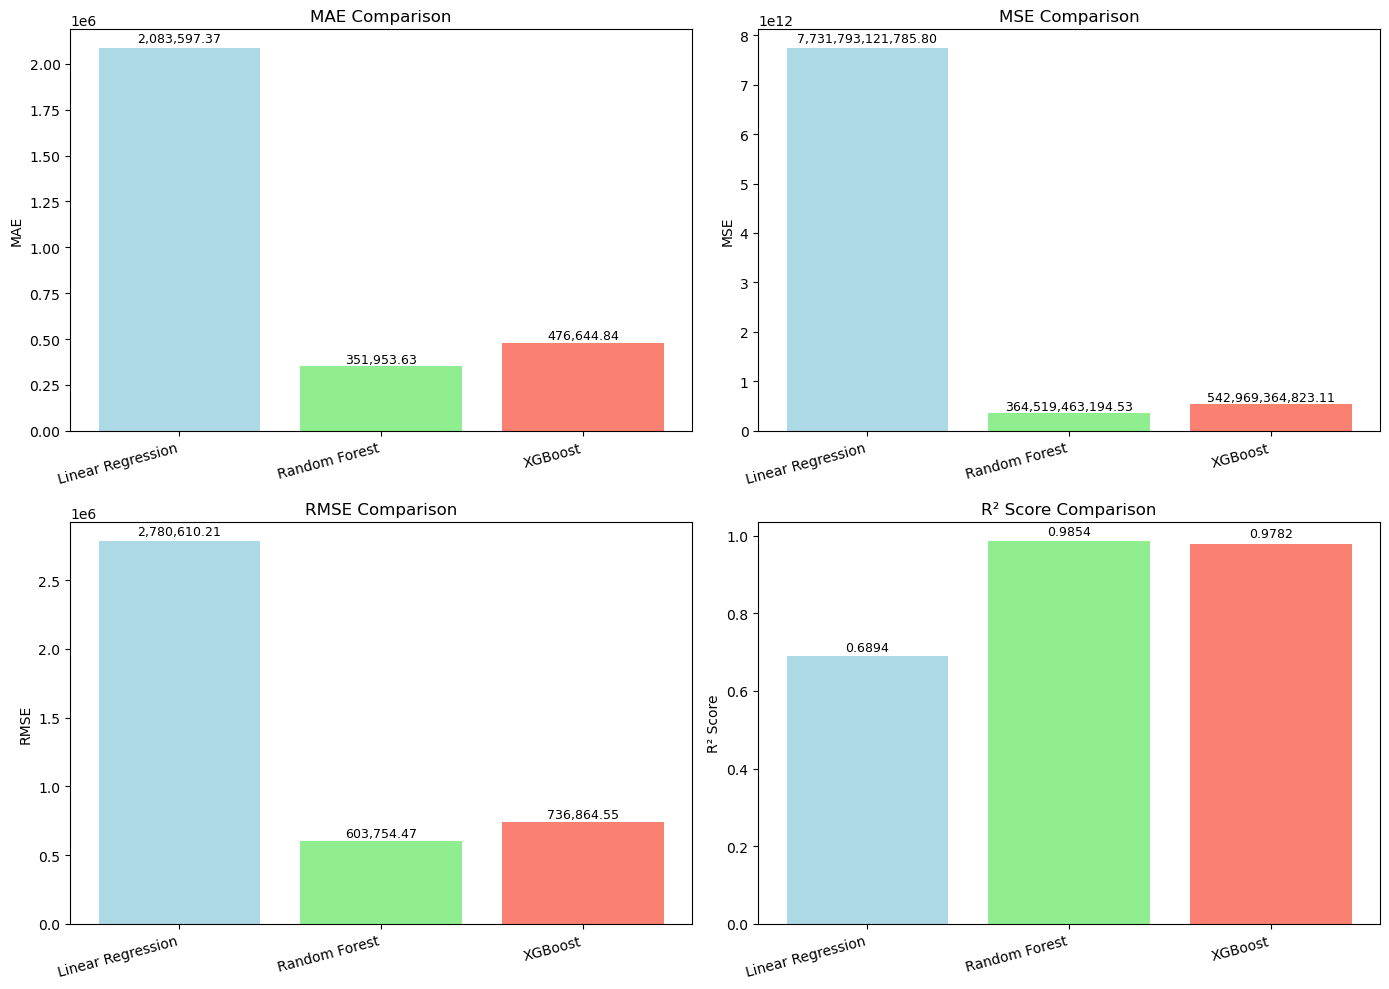

In [29]:
# 🔹 Make predictions using trained models
LinearRegrModel_pred = LinearRegrModel.predict(X_test)
randomModel_pred = randomModel.predict(X_test)
XGBModel_pred = XGBModel.predict(X_test)

# 🔹 Step 1: Define a function to compute evaluation metrics
def evaluate_metrics(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# 🔹 Step 2: Evaluate each model
linear_metrics = evaluate_metrics("Linear Regression", y_test, LinearRegrModel_pred)
rf_metrics = evaluate_metrics("Random Forest", y_test, randomModel_pred)
xgb_metrics = evaluate_metrics("XGBoost", y_test, XGBModel_pred)

# 🔹 Step 3: Organize results
model_names = [linear_metrics['Model'], rf_metrics['Model'], xgb_metrics['Model']]
mae_scores = [linear_metrics['MAE'], rf_metrics['MAE'], xgb_metrics['MAE']]
mse_scores = [linear_metrics['MSE'], rf_metrics['MSE'], xgb_metrics['MSE']]
rmse_scores = [linear_metrics['RMSE'], rf_metrics['RMSE'], xgb_metrics['RMSE']]
r2_scores = [linear_metrics['R2'], rf_metrics['R2'], xgb_metrics['R2']]

results = {
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores,
    "R² Score": r2_scores
}

# 🔹 Step 4: Plot metrics
colors = ['lightblue', 'lightgreen', 'salmon']
plt.figure(figsize=(14, 10))

for i, (metric_name, scores) in enumerate(results.items(), 1):
    ax = plt.subplot(2, 2, i)
    bars = ax.bar(range(len(model_names)), scores, color=colors)
    ax.set_title(f"{metric_name} Comparison")
    ax.set_ylabel(metric_name)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=15, ha='right')

    # Format numbers for readability
    for bar in bars:
        h = bar.get_height()
        label = f"{h:.4f}" if metric_name == "R² Score" else f"{h:,.2f}"
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01 * h, label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("Model_Regression_Metric_Comparison.png", dpi=300)
plt.show()


In [30]:
print(imsData.columns.tolist())


['MemberID', 'SavingTimesPerPeriod', 'TotalSavingCycles', 'CompletedSavingCycles', 'UserSavingsMade', 'TotalCurrentSaving', 'IkiminaCreatedYear', 'UserJoinedYear', 'EmploymentStatus', 'HasGuardian', 'Age', 'SavingStatus', 'SavingRatingFactor', 'SavingRatio', 'ExpectedLoan', 'BoostAmount', 'AllowedLoan', 'AvgSavingPerCycle', 'RemainingCycles', 'RemainingRatio', 'MembershipYears', 'IkiminaAge', 'MembershipRatio', 'IsEmployed', 'SavingFrequency_daily', 'SavingFrequency_monthly', 'SavingFrequency_weekly', 'RecentLoanPaymentStatus_Bad', 'RecentLoanPaymentStatus_Better', 'RecentLoanPaymentStatus_Excellent', 'RecentLoanPaymentStatus_Good', 'RecentLoanPaymentStatus_Poor']


In [31]:
pkl.dump(randomModel, open('randomModel_Loan_prediction_model.pkl', 'wb'))

In [32]:
pkl.dump(LinearRegrModel, open('LinearRegrModel_Loan_prediction_model.pkl', 'wb'))

In [33]:
pkl.dump(XGBModel, open('XGBModel_Loan_prediction_model.pkl', 'wb'))

In [34]:
randomModel = pkl.load(open('randomModel_Loan_prediction_model.pkl', 'rb'))

In [35]:
XGBModel = pkl.load(open('XGBModel_Loan_prediction_model.pkl', 'rb'))

In [36]:
LinearRegrModel = pkl.load(open('LinearRegrModel_Loan_prediction_model.pkl', 'rb'))


In [37]:
randomModel

RandomForestRegressor(random_state=42)

In [38]:
LinearRegrModel

LinearRegression()

In [39]:
XGBModel

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [40]:
import gradio as gr
import pandas as pd
import pickle as pkl

# Load trained models
randomModel = pkl.load(open('randomModel_Loan_prediction_model.pkl', 'rb'))
xgbModel = pkl.load(open('xgbModel_Loan_prediction_model.pkl', 'rb'))
linearRegrModel = pkl.load(open('LinearRegrModel_Loan_prediction_model.pkl', 'rb'))

# Final features (as trained)
final_features = [
    'SavingTimesPerPeriod',
    'TotalSavingCycles',
    'CompletedSavingCycles',
    'UserSavingsMade',
    'TotalCurrentSaving',
    'IkiminaCreatedYear',
    'UserJoinedYear',
    'Age',
    'HasGuardian',
    'IsEmployed',
    'SavingFrequency_daily',
    'SavingFrequency_monthly',
    'SavingFrequency_weekly',
    'RecentLoanPaymentStatus_Bad',
    'RecentLoanPaymentStatus_Better',
    'RecentLoanPaymentStatus_Excellent',
    'RecentLoanPaymentStatus_Good',
    'RecentLoanPaymentStatus_Poor'
]

def predict_loan(saving_frequency, saving_times_per_period, total_current_saving,
                 completed_saving_cycles, user_savings_made, employment_status,
                 has_guardian, recent_loan_payment_status, user_joined_year,
                 ikimina_created_year, user_age, model_choice):
    try:
        # Input validation
        for name, value in {
            "Saving Times Per Period": saving_times_per_period,
            "Total Current Saving": total_current_saving,
            "Completed Saving Cycles": completed_saving_cycles,
            "User Savings Made": user_savings_made,
            "User Joined Year": user_joined_year,
            "Ikimina Created Year": ikimina_created_year,
            "User Age": user_age
        }.items():
            if value < 0:
                return f"❌ {name} must be a non-negative number."

        if user_joined_year < ikimina_created_year:
            return "❌ User Joined Year cannot be earlier than Ikimina Created Year."

        saving_times_per_period = int(saving_times_per_period)
        if saving_frequency == 'daily' and saving_times_per_period != 1:
            return "❌ For 'daily' saving frequency, times per period must be 1."
        if saving_frequency == 'weekly' and not (1 <= saving_times_per_period <= 7):
            return "❌ For 'weekly', must be between 1 and 7."
        if saving_frequency == 'monthly' and not (1 <= saving_times_per_period <= 31):
            return "❌ For 'monthly', must be between 1 and 31."

        # Derived feature vector
        input_dict = {
            'SavingTimesPerPeriod': int(saving_times_per_period),
            'TotalSavingCycles': saving_times_per_period * (365 if saving_frequency == 'daily' else 52 if saving_frequency == 'weekly' else 12),
            'CompletedSavingCycles': int(completed_saving_cycles),
            'UserSavingsMade': int(user_savings_made),
            'TotalCurrentSaving': float(total_current_saving),
            'IkiminaCreatedYear': int(ikimina_created_year),
            'UserJoinedYear': int(user_joined_year),
            'Age': int(user_age),
            'HasGuardian': int(has_guardian),
            'IsEmployed': 1 if employment_status == 'employed' else 0,
            'SavingFrequency_daily': 1 if saving_frequency == 'daily' else 0,
            'SavingFrequency_monthly': 1 if saving_frequency == 'monthly' else 0,
            'SavingFrequency_weekly': 1 if saving_frequency == 'weekly' else 0,
            'RecentLoanPaymentStatus_Excellent': 1 if recent_loan_payment_status == 'Excellent' else 0,
            'RecentLoanPaymentStatus_Better': 1 if recent_loan_payment_status == 'Better' else 0,
            'RecentLoanPaymentStatus_Good': 1 if recent_loan_payment_status == 'Good' else 0,
            'RecentLoanPaymentStatus_Bad': 1 if recent_loan_payment_status == 'Bad' else 0,
            'RecentLoanPaymentStatus_Poor': 1 if recent_loan_payment_status == 'Poor' else 0
        }

        df = pd.DataFrame([input_dict], columns=final_features)

        # Model selection
        if model_choice == 'Random Forest':
            model = randomModel
        elif model_choice == 'XGBoost':
            model = xgbModel
        elif model_choice == 'Linear Regression':
            model = linearRegrModel
        else:
            return "❌ Invalid model selection."

        # Prediction
        prediction = model.predict(df)[0]
        return f"✅ Predicted Allowed Loan: {prediction:,.2f} RWF"

    except Exception as e:
        return f"❌ Error: {str(e)}"

# Build the Gradio interface
iface = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Radio(['daily', 'weekly', 'monthly'], label="Saving Frequency", value="daily"),
        gr.Number(label="Saving Times Per Period", value=1),
        gr.Number(label="Total Current Saving", value=0),
        gr.Number(label="Completed Saving Cycles", value=0),
        gr.Number(label="User Savings Made", value=0),
        gr.Radio(['employed', 'unemployed'], label="Employment Status", value="employed"),
        gr.Checkbox(label="Has Guardian", value=False),
        gr.Radio(['Excellent', 'Better', 'Good', 'Bad', 'Poor'], label="Recent Loan Payment Status", value="Excellent"),
        gr.Number(label="User Joined Year", value=2020),
        gr.Number(label="Ikimina Created Year", value=2015),
        gr.Number(label="User Age", value=30)
        ,
        gr.Radio(['Random Forest', 'XGBoost', 'Linear Regression'], label="Select Model", value="Random Forest")
    ],
    outputs=gr.Textbox(label="Loan Prediction Result"),
    title="IMS Loan Prediction",
    description="Enter user details to estimate allowed loan amount using selected model."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.
